In [1]:
!pip uninstall -y xgboost
!pip install xgboost==1.7.6

Found existing installation: xgboost 3.1.2
Uninstalling xgboost-3.1.2:
  Successfully uninstalled xgboost-3.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.4 MB/s eta 0:00:00


# Dataset Setup and Library Initialization

This cell sets up the Kaggle API credentials, downloads the NSL-KDD dataset, extracts it, and initializes all required libraries for preprocessing, analysis, and model evaluation.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
import pandas as pd

column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes",
    "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
    "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
    "num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
    "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
    "srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]

def clean_kdd_file(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) >= 43:
                duration = parts[42]
                row = [duration] + parts[1:42]
                data.append(row)
    df = pd.DataFrame(data, columns=column_names)

    df['label'] = df['label'].apply(lambda x: 'normal' if x.strip() == 'normal' else 'anomaly')

    return df

df_train = clean_kdd_file("/KDDTrain+.txt")
df_test = clean_kdd_file("/KDDTest+.txt")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
df_train.head()

Train shape: (41473, 42)
Test shape: (22544, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,20,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,15,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,19,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,21,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,21,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# Data Preprocessing — Encoding, Cleaning, and Scaling

In this step, categorical features (protocol_type, service, flag) are label encoded using consistent mappings across train and test sets. NaN values are detected and handled conditionally to ensure data integrity, and all numeric features are scaled using Min-Max normalization. Finally, labels are binarized into +1 for normal and -1 for anomalies, preparing the data for anomaly detection models.



In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

cat_cols = ["protocol_type", "service", "flag"]

df_train_enc = df_train.copy()
df_test_enc = df_test.copy()

combined_cat = pd.concat([df_train[cat_cols], df_test[cat_cols]], axis=0).reset_index(drop=True)

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined_cat[col] = le.fit_transform(combined_cat[col])
    encoders[col] = le

df_train_enc[cat_cols] = combined_cat.iloc[:len(df_train)][cat_cols].values
df_test_enc[cat_cols] = combined_cat.iloc[len(df_train):][cat_cols].values

for col in ['duration', 'dst_host_srv_rerror_rate']:
    df_train_enc[col] = pd.to_numeric(df_train_enc[col], errors='coerce')
    df_test_enc[col] = pd.to_numeric(df_test_enc[col], errors='coerce')

train_nan = df_train_enc['dst_host_srv_rerror_rate'].isna().sum()
test_nan = df_test_enc['dst_host_srv_rerror_rate'].isna().sum()
print(f"NaNs in 'dst_host_srv_rerror_rate' - Train: {train_nan}, Test: {test_nan}")

if train_nan > len(df_train_enc)*0.1 or test_nan > len(df_test_enc)*0.1:
    print("Dropping 'dst_host_srv_rerror_rate' due to too many NaNs")
    df_train_enc = df_train_enc.drop(columns=['dst_host_srv_rerror_rate'])
    df_test_enc = df_test_enc.drop(columns=['dst_host_srv_rerror_rate'])
else:
    df_train_enc['dst_host_srv_rerror_rate'] = df_train_enc['dst_host_srv_rerror_rate'].fillna(df_train_enc['dst_host_srv_rerror_rate'].mean())
    df_test_enc['dst_host_srv_rerror_rate'] = df_test_enc['dst_host_srv_rerror_rate'].fillna(df_test_enc['dst_host_srv_rerror_rate'].mean())

df_train_enc['duration'] = df_train_enc['duration'].fillna(df_train_enc['duration'].mean())
df_test_enc['duration'] = df_test_enc['duration'].fillna(df_test_enc['duration'].mean())

X_train = df_train_enc.drop("label", axis=1)
X_test = df_test_enc.drop("label", axis=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = df_train_enc['label'].apply(lambda x: 1 if x.strip() == "normal" else -1).values
y_test = df_test_enc['label'].apply(lambda x: 1 if x.strip() == "normal" else -1).values

print("Data preprocessing complete!")
print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

NaNs in 'dst_host_srv_rerror_rate' - Train: 0, Test: 0
Data preprocessing complete!
Train shape: (41473, 41), Test shape: (22544, 41)


# Supervised Detection Using XGBoost Classifier

In this stage, an XGBClassifier is configured with balanced class weighting and regularization to mitigate overfitting on the imbalanced intrusion data. After training with early stopping, the model's predictions are evaluated using precision, recall, and F1-score on both training and test sets. Confusion matrix and top feature importances are visualized to provide clarity on performance and feature relevance.

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



XGBoost Train Classification Report:



,precision,recall,f1-score,support
0,0.999000,0.988000,0.994000,22043.000000
1,0.987000,0.999000,0.993000,19430.000000
accuracy,0.993000,0.993000,0.993000,0.993000
macro avg,0.993000,0.994000,0.993000,41473.000000
weighted avg,0.993000,0.993000,0.993000,41473.000000



XGBoost Test Classification Report:



,precision,recall,f1-score,support
0,0.792000,0.967000,0.871000,9711.000000
1,0.970000,0.808000,0.881000,12833.000000
accuracy,0.876000,0.876000,0.876000,0.876000
macro avg,0.881000,0.887000,0.876000,22544.000000
weighted avg,0.893000,0.876000,0.877000,22544.000000


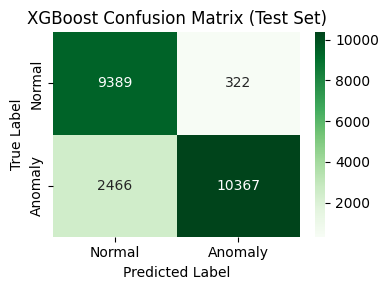

<Figure size 1000x500 with 0 Axes>

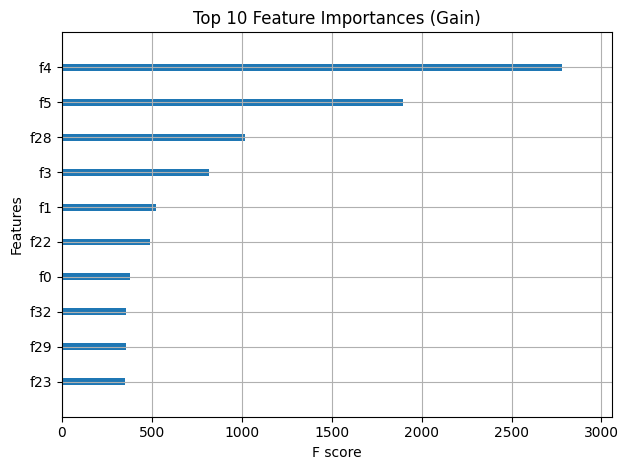

In [21]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import numpy as np

y_train_fixed = np.array([1 if x == -1 else 0 for x in y_train])
y_test_fixed = np.array([1 if x == -1 else 0 for x in y_test])

scale_ratio = np.sum(y_train_fixed == 0) / np.sum(y_train_fixed == 1)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.015,
    subsample=0.75,
    colsample_bytree=0.7,
    gamma=1,
    reg_alpha=1,
    reg_lambda=2,
    scale_pos_weight=scale_ratio,
    objective='binary:logistic',
    eval_metric=['logloss', 'auc'],
    verbosity=1,
    random_state=42
)

xgb_model.fit(
    X_train_scaled, y_train_fixed,
    eval_set=[(X_test_scaled, y_test_fixed)],
    early_stopping_rounds=20,
    verbose=False
)

y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

train_report = classification_report(y_train_fixed, y_train_pred, output_dict=True)
test_report_xgb = classification_report(y_test_fixed, y_test_pred, output_dict=True)

df_train_report = pd.DataFrame(train_report).transpose().round(3)
df_test_report = pd.DataFrame(test_report_xgb).transpose().round(3)

styles = [
    {'selector': 'th', 'props': [
        ('background-color', '#1f2937'),
        ('color', '#f9fafb'),
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'td', 'props': [
        ('background-color', '#111827'),
        ('color', '#d1d5db'),
        ('text-align', 'center'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'tr:nth-child(even)', 'props': [
        ('background-color', '#374151')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'),
        ('width', '100%')
    ]}
]

print("\nXGBoost Train Classification Report:\n")
display(df_train_report.style.set_table_styles(styles))


print("\nXGBoost Test Classification Report:\n")
display(df_test_report.style.set_table_styles(styles))

print("\n\n")

cm = confusion_matrix(y_test_fixed, y_test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\n\n")

plt.figure(figsize=(10, 5))
plot_importance(xgb_model, max_num_features=10, importance_type='gain', show_values=False)
plt.title("Top 10 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

# Outlier-Based Intrusion Detection Using Elliptic Envelope

This phase applies an unsupervised anomaly detection approach using the EllipticEnvelope, which fits a robust covariance model assuming Gaussian distribution. It identifies statistical outliers in the feature space as potential anomalies. Predictions are then evaluated using standard classification metrics and a confusion matrix for test set validation.



/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(



Elliptic Envelope Train Classification Report:



,precision,recall,f1-score,support
0,0.528000,0.528000,0.528000,22043.000000
1,0.464000,0.464000,0.464000,19430.000000
accuracy,0.498000,0.498000,0.498000,0.498000
macro avg,0.496000,0.496000,0.496000,41473.000000
weighted avg,0.498000,0.498000,0.498000,41473.000000



Elliptic Envelope Test Classification Report:



,precision,recall,f1-score,support
0,0.790000,0.661000,0.720000,9711.000000
1,0.772000,0.867000,0.817000,12833.000000
accuracy,0.779000,0.779000,0.779000,0.779000
macro avg,0.781000,0.764000,0.768000,22544.000000
weighted avg,0.780000,0.779000,0.775000,22544.000000


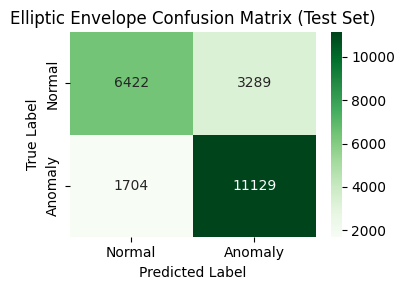

In [22]:
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
import numpy as np

y_train_fixed = np.array([1 if x == -1 else 0 for x in y_train])
y_test_fixed = np.array([1 if x == -1 else 0 for x in y_test])

ee_model = EllipticEnvelope(contamination=np.sum(y_train_fixed == 1) / len(y_train_fixed), random_state=42)

ee_model.fit(X_train_scaled)

y_train_pred = ee_model.predict(X_train_scaled)
y_test_pred = ee_model.predict(X_test_scaled)

y_train_pred_fixed = np.array([1 if x == -1 else 0 for x in y_train_pred])
y_test_pred_fixed = np.array([1 if x == -1 else 0 for x in y_test_pred])

train_report = classification_report(y_train_fixed, y_train_pred_fixed, output_dict=True)
test_report_ee = classification_report(y_test_fixed, y_test_pred_fixed, output_dict=True)

df_train_report = pd.DataFrame(train_report).transpose().round(3)
df_test_report = pd.DataFrame(test_report_ee).transpose().round(3)

styles = [
    {'selector': 'th', 'props': [
        ('background-color', '#1f2937'),
        ('color', '#f9fafb'),
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'td', 'props': [
        ('background-color', '#111827'),
        ('color', '#d1d5db'),
        ('text-align', 'center'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'tr:nth-child(even)', 'props': [
        ('background-color', '#374151')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'),
        ('width', '100%')
    ]}
]

print("\nElliptic Envelope Train Classification Report:\n")
display(df_train_report.style.set_table_styles(styles))

print("\nElliptic Envelope Test Classification Report:\n")
display(df_test_report.style.set_table_styles(styles))

print("\n\n")

cm = confusion_matrix(y_test_fixed, y_test_pred_fixed)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Elliptic Envelope Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

# Supervised Classification with Random Forest

In this step, we implement a RandomForestClassifier—a robust ensemble method leveraging multiple decision trees to improve generalization. The model is trained with class weighting to counter class imbalance and evaluated using standard classification metrics and a confusion matrix on the test set.


Random Forest Train Classification Report:



,precision,recall,f1-score,support
0,1.000000,0.999000,0.999000,22043.000000
1,0.999000,1.000000,0.999000,19430.000000
accuracy,0.999000,0.999000,0.999000,0.999000
macro avg,0.999000,0.999000,0.999000,41473.000000
weighted avg,0.999000,0.999000,0.999000,41473.000000



Random Forest Test Classification Report:



,precision,recall,f1-score,support
0,0.732000,0.971000,0.835000,9711.000000
1,0.971000,0.731000,0.834000,12833.000000
accuracy,0.834000,0.834000,0.834000,0.834000
macro avg,0.851000,0.851000,0.834000,22544.000000
weighted avg,0.868000,0.834000,0.834000,22544.000000


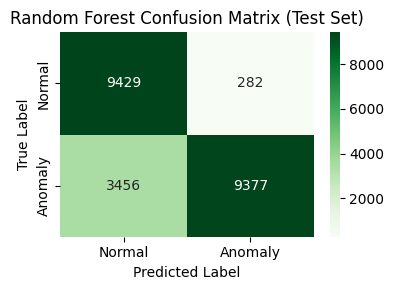

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import numpy as np

y_train_fixed = np.array([1 if x == -1 else 0 for x in y_train])
y_test_fixed = np.array([1 if x == -1 else 0 for x in y_test])

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train_fixed)

y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

train_report = classification_report(y_train_fixed, y_train_pred, output_dict=True)
test_report_rf = classification_report(y_test_fixed, y_test_pred, output_dict=True)

df_train_report = pd.DataFrame(train_report).transpose().round(3)
df_test_report = pd.DataFrame(test_report_rf).transpose().round(3)

styles = [
    {'selector': 'th', 'props': [
        ('background-color', '#1f2937'),
        ('color', '#f9fafb'),
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'td', 'props': [
        ('background-color', '#111827'),
        ('color', '#d1d5db'),
        ('text-align', 'center'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'tr:nth-child(even)', 'props': [
        ('background-color', '#374151')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'),
        ('width', '100%')
    ]}
]

print("\nRandom Forest Train Classification Report:\n")
display(df_train_report.style.set_table_styles(styles))

print("\nRandom Forest Test Classification Report:\n")
display(df_test_report.style.set_table_styles(styles))

print("\n\n")

cm = confusion_matrix(y_test_fixed, y_test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

# K-Nearest Neighbors (KNN) Based Classification

This step applies a KNeighborsClassifier with k=5 to detect anomalous connections. The algorithm classifies each test instance based on the majority label among its nearest neighbors in the training set. The model's performance is evaluated through classification metrics and a confusion matrix.




KNN Train Classification Report:



,precision,recall,f1-score,support
0,0.998000,0.998000,0.998000,22043.000000
1,0.998000,0.998000,0.998000,19430.000000
accuracy,0.998000,0.998000,0.998000,0.998000
macro avg,0.998000,0.998000,0.998000,41473.000000
weighted avg,0.998000,0.998000,0.998000,41473.000000



KNN Test Classification Report:



,precision,recall,f1-score,support
0,0.694000,0.977000,0.812000,9711.000000
1,0.975000,0.675000,0.798000,12833.000000
accuracy,0.805000,0.805000,0.805000,0.805000
macro avg,0.835000,0.826000,0.805000,22544.000000
weighted avg,0.854000,0.805000,0.804000,22544.000000


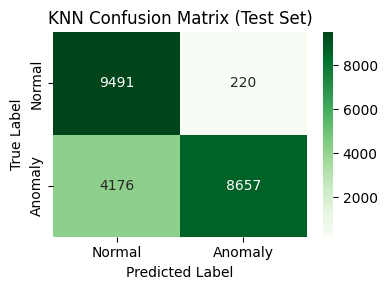

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import numpy as np

y_train_fixed = np.array([1 if x == -1 else 0 for x in y_train])
y_test_fixed = np.array([1 if x == -1 else 0 for x in y_test])

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train_fixed)

y_train_pred = knn_model.predict(X_train_scaled)
y_test_pred = knn_model.predict(X_test_scaled)

train_report = classification_report(y_train_fixed, y_train_pred, output_dict=True)
test_report_knn = classification_report(y_test_fixed, y_test_pred, output_dict=True)

df_train_report = pd.DataFrame(train_report).transpose().round(3)
df_test_report = pd.DataFrame(test_report_knn).transpose().round(3)

styles = [
    {'selector': 'th', 'props': [
        ('background-color', '#1f2937'),
        ('color', '#f9fafb'),
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'td', 'props': [
        ('background-color', '#111827'),
        ('color', '#d1d5db'),
        ('text-align', 'center'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'tr:nth-child(even)', 'props': [
        ('background-color', '#374151')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'),
        ('width', '100%')
    ]}
]

print("\nKNN Train Classification Report:\n")
display(df_train_report.style.set_table_styles(styles))

print("\nKNN Test Classification Report:\n")
display(df_test_report.style.set_table_styles(styles))

print("\n\n")

cm = confusion_matrix(y_test_fixed, y_test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNN Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

# Support Vector Machine (SVM) Classification

In this step, we apply a Support Vector Classifier with an RBF kernel to separate normal and anomalous traffic. SVM maximizes the margin between the two classes, making it suitable for high-dimensional and non-linear boundary detection. Balanced class weights help address label imbalance. Evaluation includes performance metrics and confusion matrix visualization.




SVM Train Classification Report:



,precision,recall,f1-score,support
0,0.999000,0.992000,0.996000,22043.000000
1,0.992000,0.999000,0.995000,19430.000000
accuracy,0.995000,0.995000,0.995000,0.995000
macro avg,0.995000,0.996000,0.995000,41473.000000
weighted avg,0.996000,0.995000,0.995000,41473.000000



SVM Test Classification Report:



,precision,recall,f1-score,support
0,0.811000,0.964000,0.881000,9711.000000
1,0.968000,0.830000,0.894000,12833.000000
accuracy,0.888000,0.888000,0.888000,0.888000
macro avg,0.889000,0.897000,0.887000,22544.000000
weighted avg,0.900000,0.888000,0.888000,22544.000000


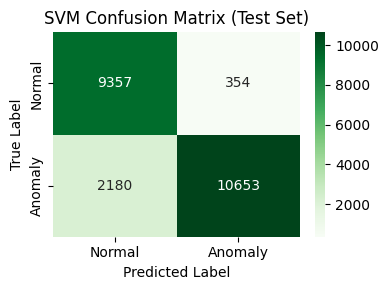

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import numpy as np

y_train_fixed = np.array([1 if x == -1 else 0 for x in y_train])
y_test_fixed = np.array([1 if x == -1 else 0 for x in y_test])

svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

svm_model.fit(X_train_scaled, y_train_fixed)

y_train_pred = svm_model.predict(X_train_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

train_report = classification_report(y_train_fixed, y_train_pred, output_dict=True)
test_report_svm = classification_report(y_test_fixed, y_test_pred, output_dict=True)

df_train_report = pd.DataFrame(train_report).transpose().round(3)
df_test_report = pd.DataFrame(test_report_svm).transpose().round(3)

styles = [
    {'selector': 'th', 'props': [
        ('background-color', '#1f2937'),
        ('color', '#f9fafb'),
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'td', 'props': [
        ('background-color', '#111827'),
        ('color', '#d1d5db'),
        ('text-align', 'center'),
        ('border', '1px solid #374151')
    ]},
    {'selector': 'tr:nth-child(even)', 'props': [
        ('background-color', '#374151')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'),
        ('width', '100%')
    ]}
]

print("\nSVM Train Classification Report:\n")
display(df_train_report.style.set_table_styles(styles))

print("\nSVM Test Classification Report:\n")
display(df_test_report.style.set_table_styles(styles))

print("\n\n")

cm = confusion_matrix(y_test_fixed, y_test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()


# Model Performance Comparison on Test Set

This bar chart summarizes key metrics — precision, recall, F1-score, and accuracy — for all models on the test data. It helps quickly visualize strengths and weaknesses of each approach for anomaly detection in network traffic.

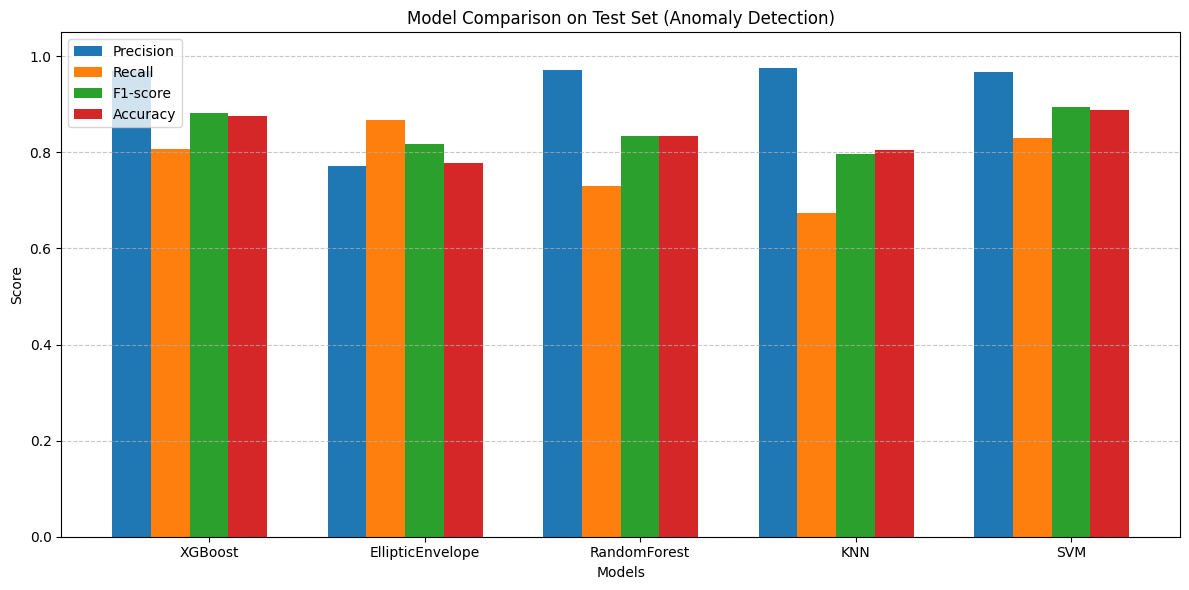

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

all_reports = {
    'XGBoost': test_report_xgb,
    'EllipticEnvelope': test_report_ee,
    'RandomForest': test_report_rf,
    'KNN': test_report_knn,
    'SVM': test_report_svm
}

metrics = ['precision', 'recall', 'f1-score', 'accuracy']

comparison_df = pd.DataFrame(columns=metrics, index=all_reports.keys())

for model_name, report in all_reports.items():
    accuracy = report['accuracy']

    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']

    comparison_df.loc[model_name] = [precision, recall, f1, accuracy]

comparison_df = comparison_df.astype(float)

plt.figure(figsize=(12, 6))
bar_width = 0.18
index = np.arange(len(comparison_df))

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, comparison_df[metric], bar_width, label=metric.capitalize())

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Comparison on Test Set (Anomaly Detection)')
plt.xticks(index + bar_width * (len(metrics)/2), comparison_df.index)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
